# Preparation

In [33]:
# import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing
from feature_engine.outliers import Winsorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

# model
from sklearn.ensemble import RandomForestClassifier

In [2]:
# opsi pada pandas untuk melihat kolom data secara keseluruhan
pd.options.display.max_columns = None

In [3]:
# code untuk menghilangkan warning
from warnings import filterwarnings
filterwarnings('ignore')

In [4]:
# load dataset
df = pd.read_csv('df_travel_V2.csv')

In [5]:
# konversi rupee ke rupiah
df['MonthlyIncome_rp'] = df['MonthlyIncome'] * 189.68

In [26]:
# membuat fungsi untuk distribusi data menggunakan histogram dan boxplot
def plot_dist(df, col):
    fig, axes = plt.subplots(ncols = 2, figsize = (15, 5))
    
    # histogram
    sns.histplot(df[col],ax = axes[0], bins=30)
    axes[0].set_title(f"Histogram '{col}'")
    axes[0].axvline(df[col].mean(), color = 'red', linestyle = 'dashed', label = 'mean')
    axes[0].axvline(df[col].median(), color = 'green', linestyle = 'dashed', label = 'median')
    axes[0].legend()
    
    # boxplot
    sns.boxplot(y=df[col], ax =  axes[1])
    axes[1].set_title(f"Boxplot '{col}'")
    
    plt.show()
    
    # skewness
    print('Skewness :', df[col].skew())
    if -0.5 <= df[col].skew() <= 0.5:
        print("Kolom '{}' berdistribusi normal".format(col))
    elif df[col].skew() > 0.5:
        print("Kolom '{}' right skewed (miring ke kanan)".format(col))
    elif df[col].skew() < -0.5:
        print("Kolom '{}' left skewed (miring ke kiri)".format(col))

# Data Preprocessing

## Split Data Inference

Untuk melakukan model inference, saya akan memisahkan 20 data sampel dari dataset awal yang selanjutnya akan disimpan dalam variabel baru bernama `df_inf`.

In [36]:
# split data inference dari dataset awal
df_inf = df.sample(20, random_state = 50)
df_inf

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,MonthlyIncome_rp
3216,203216,Not_taken,57.0,Company Invited,1,16.0,Small Business,Female,4,4.0,Basic,3.0,Divorced,4.0,0,2,0,1.0,Executive,21620.0,4100881.60
3961,203961,Not_taken,38.0,Self Enquiry,1,26.0,Salaried,Male,4,4.0,Basic,4.0,Married,6.0,0,4,0,2.0,Executive,21700.0,4116056.00
1750,201750,Not_taken,53.0,Self Enquiry,1,9.0,Small Business,Male,2,3.0,Super Deluxe,3.0,Married,4.0,1,5,1,0.0,AVP,32584.0,6180533.12
2979,202979,Not_taken,42.0,Self Enquiry,2,17.0,Salaried,Male,4,5.0,King,3.0,Married,0.0,0,2,1,1.0,VP,37819.0,7173507.92
2727,202727,Not_taken,56.0,Self Enquiry,1,27.0,Large Business,Male,3,4.0,Deluxe,3.0,Divorced,5.0,1,2,1,2.0,Manager,24093.0,4569960.24
2136,202136,Taken,45.0,Self Enquiry,1,9.0,Salaried,Female,2,3.0,Deluxe,3.0,Married,1.0,1,5,1,1.0,Manager,35421.0,6718655.28
2766,202766,Not_taken,33.0,Self Enquiry,1,9.0,Small Business,Female,4,3.0,Deluxe,3.0,Unmarried,2.0,0,3,1,3.0,Manager,23733.0,4501675.44
4143,204143,Taken,30.0,Self Enquiry,1,25.0,Small Business,Male,3,5.0,Basic,3.0,Single,3.0,1,3,0,1.0,Executive,21067.0,3995988.56
977,200977,Not_taken,34.0,Company Invited,1,32.0,Large Business,Female,3,4.0,Basic,3.0,Married,2.0,0,1,1,0.0,Executive,17029.0,3230060.72
608,200608,Taken,55.0,Self Enquiry,3,8.0,Small Business,Male,2,3.0,Deluxe,3.0,Single,5.0,0,2,0,1.0,Manager,20160.0,3823948.80


In [37]:
# cek proporsi label pada data inference
df_inf['ProductPitched'].value_counts()

Basic           8
Deluxe          8
Super Deluxe    2
King            2
Name: ProductPitched, dtype: int64

Data inference yang sudah dipisahkan lalu didrop index datanya pada dataset untuk training model agar model tidak mengalami kebocoran data karena model telah mempelajari data inference tersebut terlebih dahulu.

In [38]:
# drop index data inference pada data untuk train-val-test set
df_trainval_test = df.drop(df_inf.index)

Selanjutnya saya melakukan reset index agar penomoran data kembali sesuai urutannya pada masing-masing variabel dataset.

In [39]:
# reset index
df_trainval_test.reset_index(drop = True, inplace = True)
df_inf.reset_index(drop = True, inplace = True)

## Split Label (y) dan Fitur (X)

Label adalah variabel yang ingin diprediksi, yaitu kolom `ProductPitched`. Fitur adalah kolom-kolom yang akan dijadikan sebagai variabel penentu dalam memprediksi label.

Ketentuan Kelas Paket Holiday:
- Basic : 0 (Paket Basic)
- Deluxe, Standard : 1 (Paket Deluxe)
- Super Deluxe, King : 2 (Paket King)

In [40]:
df_trainval_test['ProductPitched'].value_counts()

Basic           1834
Deluxe          1724
Standard         742
Super Deluxe     340
King             228
Name: ProductPitched, dtype: int64

In [41]:
# split label dan fitur
X = df_trainval_test.drop(['CustomerID', 'ProductPitched', 'ProdTaken', 'TypeofContact','NumberOfFollowups', 'DurationOfPitch', 'MonthlyIncome'], axis = 1)
y = df_trainval_test['ProductPitched'].map({'Basic': 0, 'Deluxe': 1, 'Standard': 1, 'Super Deluxe': 2, 'King' : 2})

In [42]:
print('Ukuran dimensi fitur: ', X.shape)
print('Ukuran dimensi label: ', y.shape)

Ukuran dimensi fitur:  (4868, 14)
Ukuran dimensi label:  (4868,)


In [43]:
y.value_counts()

1    2466
0    1834
2     568
Name: ProductPitched, dtype: int64

## Split Data Numerik dan Kategorik

In [44]:
# list data kategorik dan numerik
cat_cols = ['CityTier', 'Occupation', 'Gender', 'MaritalStatus', 'Passport', 'OwnCar', 'Designation']
cat_cols_ord = ['PreferredPropertyStar', 'PitchSatisfactionScore']
num_cols = ['Age', 'NumberOfPersonVisiting', 'NumberOfTrips', 'NumberOfChildrenVisiting', 'MonthlyIncome_rp']

In [45]:
# looping untuk melihat value data kategorik
for i in (cat_cols): 
    print(f'Unique kolom {i} :', X[i].unique())

Unique kolom CityTier : [3 1 2]
Unique kolom Occupation : ['Salaried' 'Free Lancer' 'Small Business' 'Large Business']
Unique kolom Gender : ['Female' 'Male']
Unique kolom MaritalStatus : ['Single' 'Divorced' 'Married' 'Unmarried']
Unique kolom Passport : [1 0]
Unique kolom OwnCar : [1 0]
Unique kolom Designation : ['Manager' 'Executive' 'Senior Manager' 'AVP' 'VP']


Value kategori 'Unmarried' dan 'Single' pada kolom `MaritalStatus` dapat digabungkan menjadi satu value, yaitu 'Single'.

In [46]:
X['MaritalStatus'] = X['MaritalStatus'].replace('Unmarried', 'Single')

In [47]:
X['MaritalStatus'].value_counts()

Married     2331
Single      1590
Divorced     947
Name: MaritalStatus, dtype: int64

## Split Data Trainval-set dan Test-set

Split data antara data trainval-set dan data test-set dengan perbandingan 80% data trainval-set, dan 20% data test-set.

In [48]:
# split data trainval-set dan test-set
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size = 0.2, random_state = 50)

print('Ukuran dimensi Data Trainval-set: ', X_trainval.shape)
print('Ukuran dimensi Data Test-set: ', X_test.shape)

Ukuran dimensi Data Trainval-set:  (3894, 14)
Ukuran dimensi Data Test-set:  (974, 14)


## Split data train-set dan val-set

Split data antara data train-set dan data val-set dengan perbandingan 80% data train-set, dan 20% data val-set.

In [49]:
# split data train-set dan val-set
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size = 0.2, random_state = 50)

print('Ukuran dimensi Data Train-set: ', X_train.shape)
print('Ukuran dimensi Data Val-set: ', X_val.shape)

Ukuran dimensi Data Train-set:  (3115, 14)
Ukuran dimensi Data Val-set:  (779, 14)


## Handling Outliers pada Train-set

In [50]:
# buat batas outlier menggunakan winsorizer
winsorizer = Winsorizer(capping_method='iqr',
                         tail='both',
                         fold=1.5,
                         variables=num_cols
                         )

In [51]:
# fit dan transform metode handling outlier pada data train-set
X_train = winsorizer.fit_transform(X_train)

# transform pada data val-set dan test-set
X_val = winsorizer.transform(X_val)
X_test = winsorizer.transform(X_test)

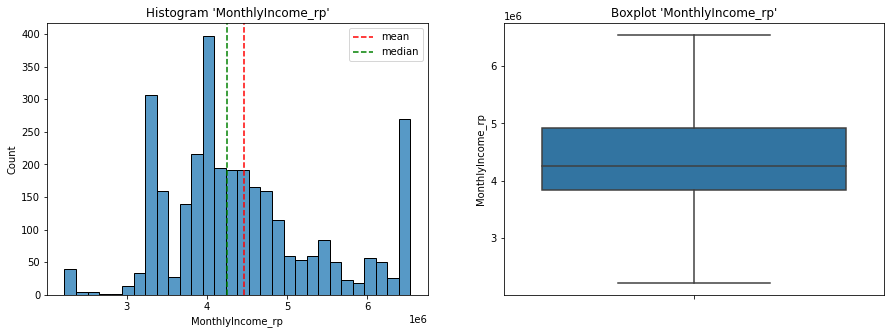

Skewness : 0.6257139717470606
Kolom 'MonthlyIncome_rp' right skewed (miring ke kanan)


In [52]:
plot_dist(X_train, 'MonthlyIncome_rp')

Setelah handling outlier, sekarang kolom numerik sudah tidak memiliki outlier.

## Data Scaling dan Encoding menggunakan Pipeline

In [53]:
# Scaler dan Encoder
scaler = RobustScaler()
ohe = OneHotEncoder()
ord = OrdinalEncoder()

# Pipeline
pipeline = ColumnTransformer([('scaler', scaler, num_cols),
                            ('ohe', ohe, cat_cols),
                            ('ordinal_encoder', ord, cat_cols_ord)],
                            remainder='passthrough')

In [54]:
# fit dan transform pipeline pada train-set
X_train_final = pipeline.fit_transform(X_train)

# transform pipeline pada val-set dan test-set
X_val_final = pipeline.transform(X_val)
X_test_final = pipeline.transform(X_test)

In [60]:
# features name hasil one hot encoder
ohe_features = pipeline.named_transformers_['ohe'].get_feature_names().tolist()
ohe_features

['x0_1',
 'x0_2',
 'x0_3',
 'x1_Free Lancer',
 'x1_Large Business',
 'x1_Salaried',
 'x1_Small Business',
 'x2_Female',
 'x2_Male',
 'x3_Divorced',
 'x3_Married',
 'x3_Single',
 'x4_0',
 'x4_1',
 'x5_0',
 'x5_1',
 'x6_AVP',
 'x6_Executive',
 'x6_Manager',
 'x6_Senior Manager',
 'x6_VP']

In [62]:
X_train.head(10)

,Age,CityTier,Occupation,Gender,NumberOfPersonVisiting,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome_rp
1521,35.0,3,Salaried,Male,3.0,5.0,Married,2.0,0,4,0,0.0,Senior Manager,4565407.92
3905,31.0,1,Salaried,Male,4.0,3.0,Married,3.0,0,3,1,3.0,Executive,4053651.28
4340,49.0,3,Small Business,Female,3.0,3.0,Married,4.0,0,5,1,1.0,Manager,4311236.72
1706,32.0,3,Small Business,Male,3.0,3.0,Married,1.0,0,4,1,1.0,Manager,2685489.44
1156,45.0,1,Salaried,Female,2.0,3.0,Married,2.0,0,4,1,1.0,Manager,3939653.60
3528,46.0,1,Large Business,Male,4.0,4.0,Married,3.0,0,3,1,2.0,Senior Manager,4954251.92
1870,52.0,1,Small Business,Male,2.0,3.0,Married,3.0,1,1,1,0.0,Senior Manager,4356759.92
1668,40.0,1,Small Business,Male,1.0,3.0,Married,1.0,1,1,1,0.0,Manager,3365112.88
4070,31.0,1,Small Business,Male,4.0,5.0,Married,3.0,0,1,1,2.0,Manager,4125540.00
960,38.0,3,Salaried,Female,2.0,5.0,Married,4.0,0,4,0,1.0,Manager,4152664.24


In [61]:
# convert ke dataframe
X_train_final_df = pd.DataFrame(X_train_final, columns = num_cols + ohe_features + cat_cols_ord)
X_train_final_df.head(10)

,Age,NumberOfPersonVisiting,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome_rp,x0_1,x0_2,x0_3,x1_Free Lancer,x1_Large Business,x1_Salaried,x1_Small Business,x2_Female,x2_Male,x3_Divorced,x3_Married,x3_Single,x4_0,x4_1,x5_0,x5_1,x6_AVP,x6_Executive,x6_Manager,x6_Senior Manager,x6_VP,PreferredPropertyStar,PitchSatisfactionScore
0,-0.076923,0.0,-0.5,-1.0,0.292679,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,3.0
1,-0.384615,1.0,0.0,2.0,-0.182154,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
2,1.000000,0.0,0.5,0.0,0.056846,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0
3,-0.307692,0.0,-1.0,0.0,-1.451602,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
4,0.692308,-1.0,-0.5,0.0,-0.287927,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0
5,0.769231,1.0,0.0,1.0,0.653467,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0
6,1.230769,-1.0,0.0,-1.0,0.099085,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.307692,-2.0,-1.0,-1.0,-0.821014,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,-0.384615,1.0,0.0,1.0,-0.115452,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0
9,0.153846,-1.0,0.5,0.0,-0.090285,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,3.0


## Features Importance - Random Forest

In [63]:
# model Random Forest
ranfor = RandomForestClassifier(random_state = 10)

In [64]:
# fit model random forest pada data train-set
ranfor.fit(X_train_final, y_train)

RandomForestClassifier(random_state=10)

In [65]:
# membuat tabel dataframe yang menyimpan nilai features importance
importance_table = pd.DataFrame({
    'imp':ranfor.feature_importances_
    }, index = X_train_final_df.columns)

In [66]:
# membuat kolom baru hasil features importance dengan satuan persen
importance_table['imp_percentage'] = importance_table['imp'] * 100

In [67]:
# Hasil features importance diurutkan dari yang paling berbobot dalam menentukan label
importance_table.sort_values(['imp'], ascending= False)

,imp,imp_percentage
x6_Executive,0.302209,30.220931
x6_Manager,0.214927,21.492690
MonthlyIncome_rp,0.155738,15.573766
x6_Senior Manager,0.103292,10.329154
x6_AVP,0.086655,8.665510
x6_VP,0.053521,5.352100
Age,0.037595,3.759451
x0_3,0.010189,1.018907
x0_1,0.007793,0.779266
NumberOfTrips,0.005992,0.599189


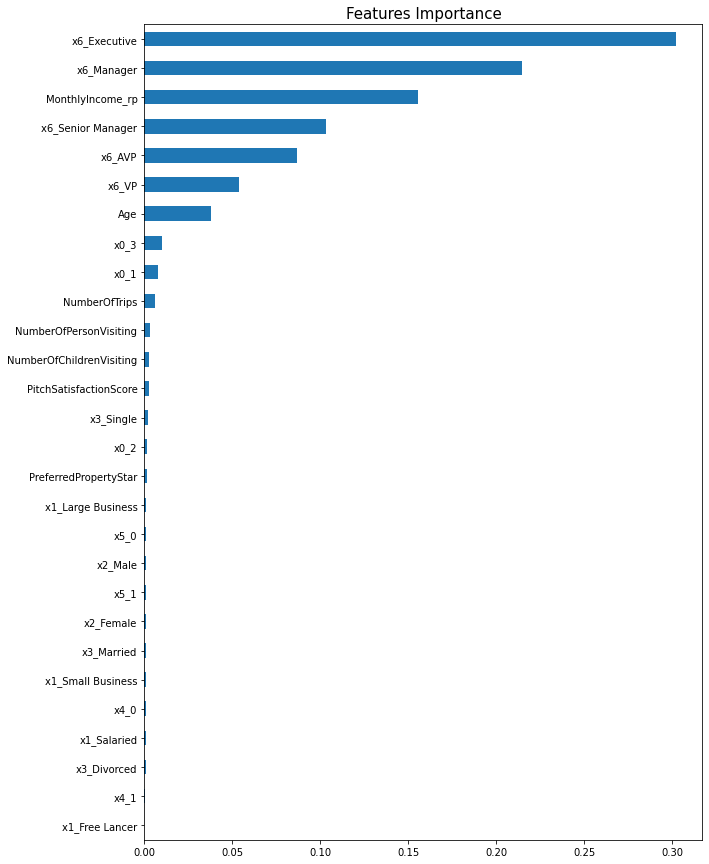

In [68]:
# visualisasi feature importance menggunakan bar plot horizontal
importance_table['imp'].sort_values().plot(kind = 'barh', figsize = (10,15))
plt.title('Features Importance', size = 15)
plt.show()

In [69]:
X_train_final_df.columns

Index(['Age', 'NumberOfPersonVisiting', 'NumberOfTrips',
       'NumberOfChildrenVisiting', 'MonthlyIncome_rp', 'x0_1', 'x0_2', 'x0_3',
       'x1_Free Lancer', 'x1_Large Business', 'x1_Salaried',
       'x1_Small Business', 'x2_Female', 'x2_Male', 'x3_Divorced',
       'x3_Married', 'x3_Single', 'x4_0', 'x4_1', 'x5_0', 'x5_1', 'x6_AVP',
       'x6_Executive', 'x6_Manager', 'x6_Senior Manager', 'x6_VP',
       'PreferredPropertyStar', 'PitchSatisfactionScore'],
      dtype='object')

Dari hasil features importances diatas kita dapat melihat fitur-fitur mana saja yang paling penting dalam menentukan label. Penentuan fitur yang akan dipilih adalah sebagai berikut:
1. Seluruh value kolom `Designation` (x6) --> No. Index 21, 22, 23, 24, dan 25
2. Kolom `MonthlyIncome_rp` --> No. Index 4
3. Kolom `Age` --> No. Index 0  
  
No. Index sisanya akan di drop karena fitur-fitur tersebut bobotnya yang terlalu kecil dalam menentukan label.

In [71]:
# list nomor index yang akan di drop berdasarkan features importance
feat_imp_drop = [1,2,3,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,26,27]

In [72]:
# ukuran dimensi kolom data sebelum dilakukan drop features
X_train_final.shape[1]

28

In [73]:
# drop kolom berdasarkan features importances
X_train_final = np.delete(X_train_final, np.s_[feat_imp_drop], axis=1)
X_val_final = np.delete(X_val_final, np.s_[feat_imp_drop], axis=1)
X_test_final = np.delete(X_test_final, np.s_[feat_imp_drop], axis=1)

In [74]:
# ukuran dimensi kolom data setelah dilakukan drop features
X_train_final.shape[1]

7

Features selection telah berhasil dilakukan, kita telah menghapus fitur yang tidak terlalu berpengaruh dalam menentukan label berdasarkan features importance random forest. Jumlah fitur yang akan digunakan untuk training model adalah 7 fitur.